# Visualize ECE using multiple neural networks.

**Author: Skorik Sergey**

## The task

Visualize ECE using multiple neural networks. Data: a toy-dataset from sklearn. Model: a one-layer neural netwok. Plot: ECE with different number of neural networks.

## Theory

__Motivation:__

In real-world decision making systems, classification networks must not only be accurate, but also should indicate when they are likely to be incorrect. As an example, consider a self-driving car that uses a neural network to detect
pedestrians and other obstructions. If the detection network is not able to confidently predict the presence or absence of immediate obstructions, the car should rely more on the output of other sensors for braking.

Specifically, a network should provide a _calibrated confidence_
measure in addition to its prediction. In other words, the
probability associated with the predicted class label should
reflect its ground truth correctness likelihood.


__Definitions:__

The input $X \in \mathcal{X}$ and the label $y \in \mathcal{Y} = \{1, 2, \ldots, K\}$ are random variables that follow a ground truth joint distribution $\pi(X, Y) = \pi(Y | X)\pi(X)$. Let $h$ be a neural network with $h(X) = (\hat{Y}, \hat{P})$, where $\hat{Y}$ is a class prediction and $\hat{P}$ is its associated confidence, i.e. probability of correctness.

Define _perfect calibration_ as 
$$\mathbb{P}(\hat{Y}=Y \mid \hat{P} = p) = p \quad \forall \, p \in [0, 1]$$
To estimate the expected accuracy from finite samples, we group predictions into $M$ interval bins (each of size $1/M$) and calculate the accuracy of each bin. Let $B_m$ be the set of indices of samples whose prediction confidence falls into the interval $I_m = \left(\frac{m-1}{M}, \frac{m}{M}\right)$ The accuracy of $B_m$ is
$$acc(B_m) = \dfrac{1}{|B_{m}|}\sum_{i \in B_m}\mathbf{1}[\hat{y}_i=y_i]$$
where $\hat{y}_i$ and $y_i$ are the predicted and true class labels for sample $i$.

Define the average confidence within bin $B_m$ as
$$conf(B_m) = \dfrac{1}{|B_{m}|}\sum_{i \in B_m}\hat{p}_i$$

One notion of miscalibration is the difference in expectation between confidence and accuracy, i.e.
$$\mathbb{E}_{\hat{P}}\left[\big|\mathbb{P}(\hat{Y}=Y \mid \hat{P} = p) - p\big|\right]$$
Excpected calibration error approximates this miscalibration in terms of $M$ bins.
$$\text{ECE} = \sum_{m=1}^M \dfrac{|B_m|}{n}\big|acc(B_m) - conf(B_m)\big|$$
where $n$ is the number of samples. The difference between acc and conf for a given bin represents the calibration gap

![](https://drive.google.com/uc?export=view&id=1HnaT7I1nQsT99HATLpXI-Vo1PbXRKRMU)

## Experiment



### Imports

In [1]:
## JAX imports
import jax
import jax.numpy as jnp
from jax import random

import numpy as np

## Flax (NN in JAX)
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax
from flax import linen as nn
from flax.training.train_state import TrainState

## Optax (Optimizers in JAX)
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

## Sklearn toy dataset
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

##Logging
from tqdm import tqdm
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.2/214.2 KB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.2/74.2 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.7/238.7 KB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 KB 6.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.


### Load data

In [2]:
X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
print(X_train.shape, X_val.shape, X_test.shape)

(1149, 64) (288, 64) (360, 64)


In [3]:
X_train[0].shape[0]

64

### Pipeline

In [4]:
class BaseConfig:
    batch_size=16
    num_classes = 10
    max_networks = 10
    step = 2
    pass

In [5]:
class Perceptron(nn.Module):
    n_classes: int

    @nn.compact
    def __call__(self, x):
        return nn.Dense(self.n_classes)(x)

In [6]:
def create_train_state(rng, tx):
  """Creates initial `TrainState`."""
  model = Perceptron(BaseConfig.num_classes)
  params = model.init(rng, jnp.ones(shape=X_train[0].shape))['params'] # initialize parameters by passing a template input
  return TrainState.create(apply_fn=model.apply, params=params, tx=tx)

In [7]:
@jax.jit
def loss_fn(logits, labels):
    labels_onehot = jax.nn.one_hot(labels, num_classes=BaseConfig.num_classes)
    return optax.softmax_cross_entropy(logits=logits, labels=labels_onehot).mean()

@jax.jit
def train_step(state, input, labels):
    def loss_f(params):
        logits = state.apply_fn({'params': params}, input)
        return loss_fn(logits, labels)
    grad_fn = jax.value_and_grad(loss_f)
    loss, grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

@jax.jit
def validate(X_val, y_val, state):
    logits = state.apply_fn({'params': state.params}, X_val)
    return loss_fn(logits, y_val)

def train_epoch(state, epoch, X_train, y_train):
    """Train for a single epoch."""
    train_loss = []
    bs = BaseConfig.batch_size
    for it in range(X_train.shape[0] // bs):
        input = X_train[it*bs:(it+1)*bs]
        labels = y_train[it*bs:(it+1)*bs]
        state, loss = train_step(state, input, labels)
        train_loss.append(loss.item())
    return state, train_loss

def train_model(X_train, y_train, X_test, y_test, state, epochs=100, epochs_no_improve=10):
    best_loss = jnp.inf
    best_model = None
    patience = 0
    train_losses = []
    for epoch in tqdm(range(epochs)):
        state, train_loss = train_epoch(state, epoch, X_train, y_train)
        validate_loss = validate(X_test, y_test, state)
        train_losses.extend(train_loss)
        if validate_loss < best_loss:
            best_loss = validate_loss
            best_model = state.params
            patience = 0
        if patience == epochs_no_improve:
            print("Early stopping")
            return state, train_losses, best_loss
        patience += 1
    return best_model, train_losses, best_loss

### Training models

In [ ]:
train_losses = {}
val_losses = {}
params = {}

for i in range(BaseConfig.max_networks):
    print(f"Model {i}:")
    ids = np.random.choice(X_train.shape[0], size=(X_train.shape[0], ))
    state = create_train_state(random.PRNGKey(i), optax.adam(1e-3))
    best_params, train_loss, val_loss = train_model(X_train[ids], y_train[ids], X_val, y_val, state)
    print('Model: %d best_loss: %.4f' % (i, val_loss))
    params[i] = best_params
    train_losses[i] = train_loss
    val_losses[i] = val_loss
    print("-----------------------------")

Model 0:


 89%|████████▉ | 89/100 [00:13<00:01,  6.60it/s]


Early stopping
Model: 0 best_loss: 0.1207
-----------------------------
Model 1:


 92%|█████████▏| 92/100 [00:11<00:01,  7.81it/s]


Early stopping
Model: 1 best_loss: 0.2106
-----------------------------
Model 2:


100%|██████████| 100/100 [00:05<00:00, 17.68it/s]


Model: 2 best_loss: 0.1260
-----------------------------
Model 3:


 74%|███████▍  | 74/100 [00:03<00:01, 22.42it/s]


Early stopping
Model: 3 best_loss: 0.1132
-----------------------------
Model 4:


 87%|████████▋ | 87/100 [00:04<00:00, 18.53it/s]


Early stopping
Model: 4 best_loss: 0.1203
-----------------------------
Model 5:


 63%|██████▎   | 63/100 [00:02<00:01, 22.46it/s]


Early stopping
Model: 5 best_loss: 0.2018
-----------------------------
Model 6:


 98%|█████████▊| 98/100 [00:04<00:00, 23.94it/s]


Early stopping
Model: 6 best_loss: 0.1403
-----------------------------
Model 7:


100%|██████████| 100/100 [00:05<00:00, 17.07it/s]


Model: 7 best_loss: 0.1344
-----------------------------
Model 8:


 89%|████████▉ | 89/100 [00:04<00:00, 21.77it/s]


Early stopping
Model: 8 best_loss: 0.1346
-----------------------------
Model 9:


100%|██████████| 100/100 [00:04<00:00, 23.94it/s]

Model: 9 best_loss: 0.0819
-----------------------------


Text(0.5, 0.98, 'Train losses')

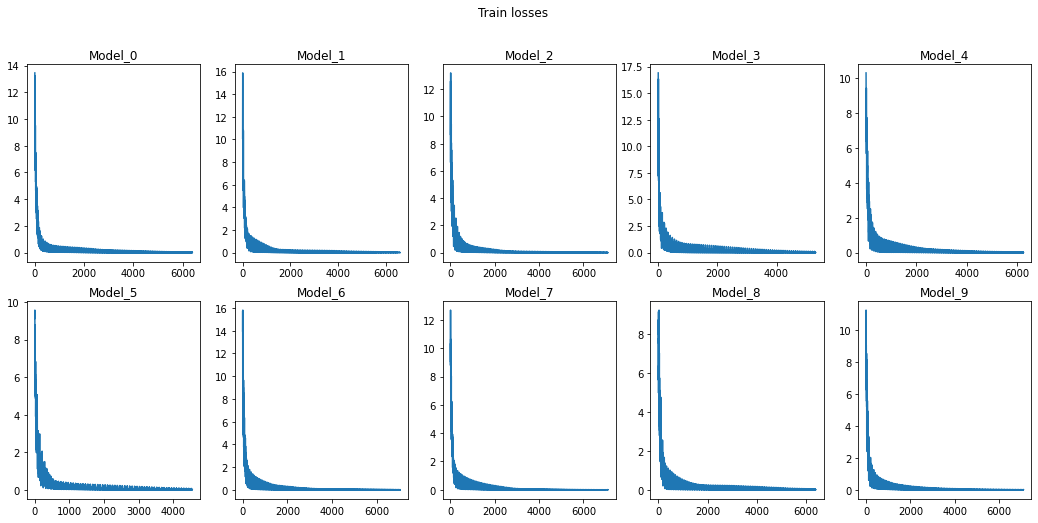

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(18, 8))
for i in range(BaseConfig.max_networks):
    axs[i//5, i%5].plot(train_losses[i])
    axs[i//5, i%5].set_title(f'Model_{i}')
fig.suptitle("Train losses")

In [ ]:
model = Perceptron(BaseConfig.num_classes)
probs = []
for model_params in params.values():
    if hasattr(model_params, 'params'):
        model_params = model_params.params
    model_probs = nn.activation.softmax(model.apply({'params': model_params}, X_test))
    probs.append(jnp.asarray(model_probs))

### ECE metric

In [8]:
def ECE(y_test, probs, m_bins=3):
    ids = np.argmax(probs, axis=1)
    vals = probs[np.arange(len(probs)), ids]
    boundaries = [m / m_bins for m in range(1, m_bins)]
    bins = np.searchsorted(boundaries, vals)
    stats = {'accuracy': [], 'confidence': [], 'difference': []}
    for m in range(m_bins):
        bin_ids = np.where(bins == m)
        bin_ids = bin_ids[0]
        if len(bin_ids) == 0:
            print(f"For bin_{m} no one value is entired")
            stats['accuracy'].append(0)
            stats['confidence'].append(0)
            stats['difference'].append(0)
            continue
        bin_classes = ids[bin_ids]
        bin_vals = vals[bin_ids]
        bin_labels = y_test[bin_ids]
        bin_acc = np.mean(np.equal(bin_classes, bin_labels))
        bin_con = np.mean(bin_vals)
        stats['accuracy'].append(round(bin_acc, 2))
        stats['confidence'].append(round(bin_con.item(), 2))
        stats['difference'].append(len(bin_ids) * np.abs(bin_acc - bin_con))
    return stats

def plot_ECE(stats, suptitle='', ax=None):
    if ax is None:
        ax = plt.gca()
    plt.style.use('ggplot')
    m_bins = len(stats['accuracy'])
    coordinates = stats['confidence']
    width = [coordinates[i]-coordinates[i-1]-1e-3 for i in range(1, len(coordinates))]
    width.insert(0, coordinates[0])
    ax.bar(coordinates, height=coordinates, width=-np.array(width), 
                align='edge', color='r', linewidth=0.1, alpha=0.6, label='gap')
    ax.bar(coordinates, height=stats['accuracy'], width=-np.array(width), 
            align='edge', color='b', linewidth=0.1, alpha=0.8, label='Outputs')
    ax.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), color='k', linestyle='dashed', linewidth=1.5)
    ax.set_xlabel('confidence')
    ax.set_ylabel('accuracy')
    ECE_error = round(sum(stats['difference']) / BaseConfig.num_classes, 2)
    ax.set_title(f"{suptitle}, Error: {ECE_error}")
    ax.legend()
    # pass
    # init_data = []
    # acc_data = []
    # for bin, acc in zip(stats['confidence'], stats['accuracy']):
    #     if bin == 0:
    #         continue
    #     else:
    #         val = bin - 1e-6
    #         init_data.extend([val]*int(bin*100))
    #         acc_data.extend([val]*int(acc*100))
    # plt.hist(init_data, bins=stats['confidence'])
    # plt.hist(acc_data, bins=stats['confidence'])

In [ ]:
single_stats = []
for i, prob in enumerate(probs):
    print(f"Model_{i}")
    stats = ECE(y_test, prob, m_bins=5)
    single_stats.append(stats)
    print("-------------")

Model_0
For bin_0 no one value is entired
For bin_1 no one value is entired
-------------
Model_1
For bin_0 no one value is entired
For bin_1 no one value is entired
-------------
Model_2
For bin_0 no one value is entired
For bin_1 no one value is entired
-------------
Model_3
For bin_0 no one value is entired
For bin_1 no one value is entired
-------------
Model_4
For bin_0 no one value is entired
For bin_1 no one value is entired
-------------
Model_5
For bin_0 no one value is entired
For bin_1 no one value is entired
-------------
Model_6
For bin_0 no one value is entired
For bin_1 no one value is entired
-------------
Model_7
For bin_0 no one value is entired
For bin_1 no one value is entired
-------------
Model_8
For bin_0 no one value is entired
For bin_1 no one value is entired
-------------
Model_9
For bin_0 no one value is entired
For bin_1 no one value is entired
-------------


### Single Comparing

Text(0.5, 0.98, 'Single Comparing')

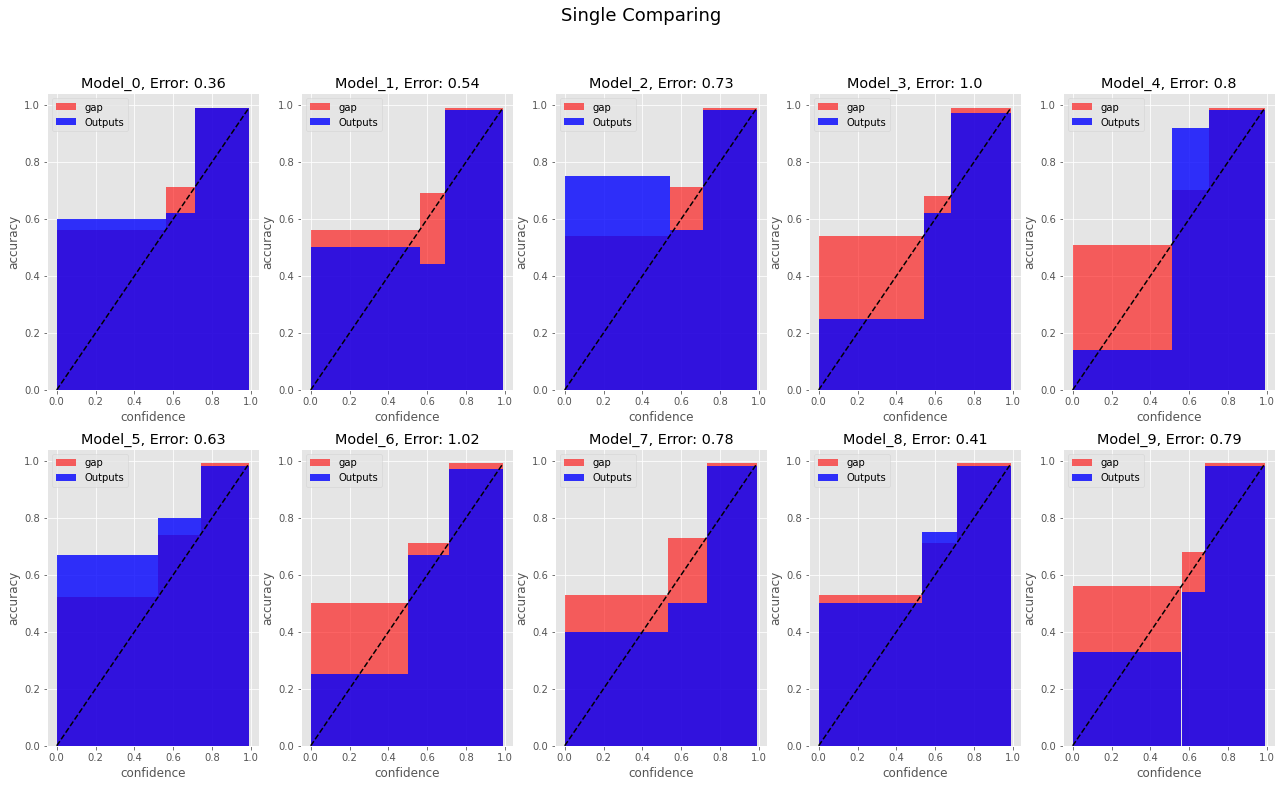

In [ ]:
f, axes = plt.subplots(2, 5, figsize=(22,12))

for i in range(BaseConfig.num_classes):
    plot_ECE(single_stats[i], suptitle=f'Model_{i}', ax=axes[i//5, i%5])
f.suptitle("Single Comparing", fontsize=18)

### Multiple networks comparing

In [ ]:
probs_018 = (probs[0] + probs[1] + probs[8]) / 3
probs_36 = (probs[3] + probs[6]) / 2
probs_01234 = (probs[0] + probs[1] + probs[2] + probs[3] + probs[4]) / 5
probs_0123456 = (probs[0] + probs[1] + probs[2] + probs[3] + probs[4] + probs[5] + probs[6]) / 7
all_probs = (probs[0] + probs[1] + probs[2] + probs[3] + probs[4] + probs[5] + probs[6] + probs[7] + probs[8] + probs[9]) / 10

multiple_probs = [probs[0], probs_36, probs_018, probs_01234, probs_0123456, all_probs]

In [ ]:
multiple_stats = []
for i, prob in enumerate(multiple_probs):
    print(f"Model_{i}")
    stats = ECE(y_test, prob, m_bins=5)
    multiple_stats.append(stats)
    print("-------------")

Model_0
For bin_0 no one value is entired
For bin_1 no one value is entired
-------------
Model_1
For bin_0 no one value is entired
-------------
Model_2
For bin_0 no one value is entired
For bin_1 no one value is entired
-------------
Model_3
For bin_0 no one value is entired
For bin_1 no one value is entired
-------------
Model_4
For bin_0 no one value is entired
-------------
Model_5
For bin_0 no one value is entired
For bin_1 no one value is entired
-------------


Text(0.5, 0.98, 'Multiple Comparing')

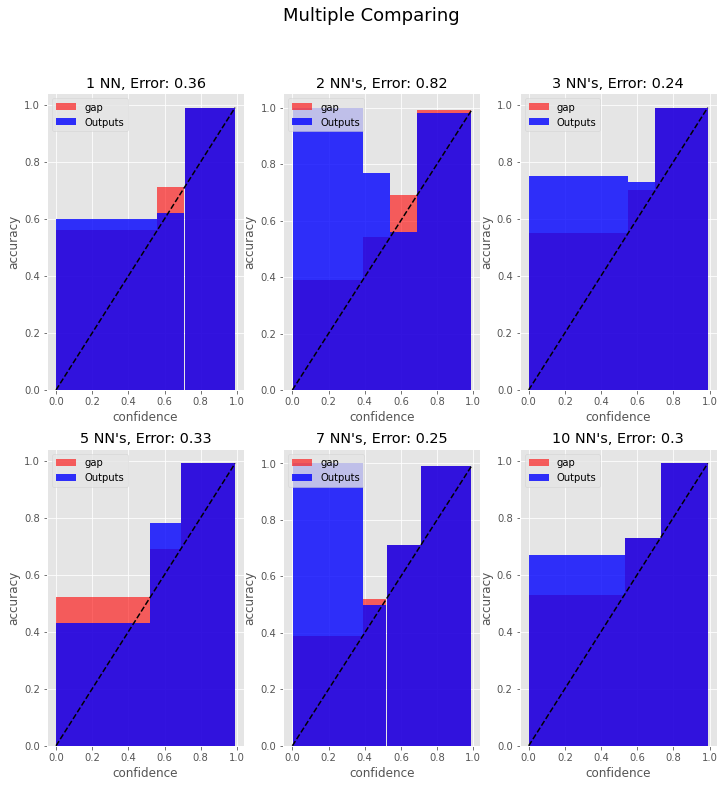

In [ ]:
f, axes = plt.subplots(2, 3, figsize=(12,12))
titles = ['1 NN', '2 NN\'s', '3 NN\'s', '5 NN\'s', '7 NN\'s', '10 NN\'s']

for i in range(6):
    plot_ECE(multiple_stats[i], suptitle=titles[i], ax=axes[i//3, i%3])
f.suptitle("Multiple Comparing", fontsize=18)

## Conclusion


According to the Dirichlet rule, for n classes, you cannot use more than m=n bins. In practice, for 10 classes it was possible to use only 3 bins. This directly affects the accuracy of the miscalibration approximation by the ECE metric. Despite this, the work confirms the main hypothesis: the ensemble of models is better calibrated than averaging them separately. Really, 


*   2 ensemble NN's: Error=0.82 < (1.0 + 1.02) / 2 = 1.01
*   3 ensemble NN's: Error=0.24 < (0.36 + 0.54 + 0.41) / 3 = 0.44
*   ...Same logic

However, the main contribution is still made by individual models. Thus, separately well-calibrated models 3 and 6 in the ensemble show the ECE error less than the ensemble of all models.